In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fqs import *
import copy
import os
import pickle

In [4]:
from tqdm.notebook import tqdm
from itertools import product

0 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

0 0.2


  0%|          | 0/100 [00:00<?, ?it/s]

0 0.3


  0%|          | 0/100 [00:00<?, ?it/s]

1 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

1 0.2


  0%|          | 0/100 [00:00<?, ?it/s]

1 0.3


  0%|          | 0/100 [00:00<?, ?it/s]

2 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

2 0.2


  0%|          | 0/100 [00:00<?, ?it/s]

2 0.3


  0%|          | 0/100 [00:00<?, ?it/s]

3 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

3 0.2


  0%|          | 0/100 [00:00<?, ?it/s]

3 0.3


  0%|          | 0/100 [00:00<?, ?it/s]

4 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

4 0.2


  0%|          | 0/100 [00:00<?, ?it/s]

4 0.3


  0%|          | 0/100 [00:00<?, ?it/s]

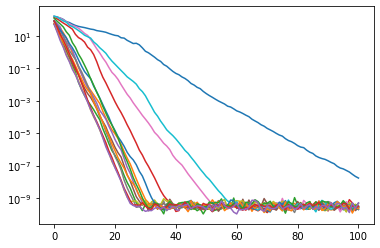

In [138]:
m = 100
n = 50
k = 2
# p = 0.2;  
# p = 0.1; etas = [2**-18]
# p = 0.05; etas = [2**-19]
# p = 0.3; etas = [2**-16,2**-17]
# for SEED in range(10):
for SEED, p in product(range(5),[0.1,0.2, 0.3]):
# for SEED, p in product(range(1),[0.05]):
    
    print(SEED, p)
    np.random.seed(SEED)
    Us = np.random.randn(m,k)
    VTs = np.random.randn(k,n)

    A = Us @ VTs
    np.random.seed(SEED+1)
    OmegaOrig = []
    for i in range(n):
        for j in range(m):
            if np.random.rand(1)<p:
                OmegaOrig.append([j,i])
    np.random.shuffle(OmegaOrig)
    len(OmegaOrig), m*n


    prefix = "./logs/matrix_completition_%d_%d_%d_%f_SEED_%d_"%(m,n,k,p, SEED)

    
    logfile = "%s_SPS_v5_Approach.pkl"%(prefix)

#     if os.path.exists(logfile):
#         continue
    

    np.random.seed(SEED)
    Omega = copy.deepcopy(OmegaOrig)


    M = A*0
    for (i,j) in Omega:
        M[i,j] = A[i,j]

    Minit = n*m/(len(Omega)+0.0)*M    
    u, s, vh = np.linalg.svd(Minit,full_matrices=False)

    s = s[:k]
    u = u[:,:k] 
    vh = vh[:k,:] 

    u = u * np.sqrt(s)
    vh = vh*np.sqrt(s).reshape([-1,1])


    Uinit = u
    VTinit = vh


    u, s, vh = np.linalg.svd(Minit,full_matrices=False)

    s = s[:k+1]
    u = u[:,:k+1] 
    vh = vh[:k+1,:] 

    u = u * np.sqrt(s)
    vh = vh*np.sqrt(s).reshape([-1,1])


    UinitPlusOne = u
    VTinitPlusOne = vh
    
    
    fval = []

    U = copy.deepcopy(Uinit)
    VT = copy.deepcopy(VTinit) 



    np.random.seed(SEED)

    rs = [[] for j in range(m)]
    cs = [[] for i in range(n)]

    for j, i in OmegaOrig:
        rs[j].append(i)
        cs[i].append(j)
     

    np.random.seed(SEED)

    Mp = U@VT  
    fval.append(np.linalg.norm(Mp - A))



    for ep in tqdm(range(100)):


        for it in range(1000):

            j = np.random.randint(m)
            i = np.random.randint(n)        

            u = U[j,:]
            v = VT[:,i]
            uv = u.dot(v)
            a = A[j,i]

            r = a - uv
            if np.abs(r) < 1e-18:
#                 adadsasd
                continue
                 
            if np.linalg.norm(u-v) < 1e-10 and uv >= 4*a:
                vn = 0.5*v + 0.5*v / np.linalg.norm(v)* np.sqrt(v.dot(v)-4*a)
                un = -0.5*u + 0.5*u / np.linalg.norm(u)* np.sqrt(u.dot(u)-4*a)
                U[j,:] =    vn
                VT[:,i]=    un
                
                asfsafa
            else:
                
                
                
                p = [  
                     -a       ,    #  g-4  
                      0        ,  # g3     
                     uv  + 2*a  ,        # g2         
                    -u.dot(u) - v.dot(v),            # g1              
                     uv - a      ,     # g0 
                ]
                
                
#                 p = [-r-uv, 0, 3*uv+2*r, -u.dot(u)-v.dot(v), -r]

                roots = quartic_roots(p)
#                 solidx =  np.argmin(np.abs(np.imag(roots)))
#                 lmbd = np.real(roots[0][solidx])
            
            
                rootssubsetion = roots[np.abs(np.imag(roots)) < 1e-8]

#                 solidx = np.argmax(np.abs(rootssubsetion))
#                 lmbd = np.real(rootssubsetion[solidx])

# #                 asfsafsafa
                
#                 nu = 1/(1-lmbd**2) * (u -lmbd* v)
#                 nv = 1/(1-lmbd**2) * (v -lmbd* u)
#                 print("----",lmbd)
#                 print(nu.dot(nv),a, np.linalg.norm(u-nu),np.linalg.norm(v-nv) )
                       

                solidx = np.argmin(np.abs(rootssubsetion))
                lmbd = np.real(rootssubsetion[solidx])

                if np.abs(np.array([lmbd**j for j in range(4,-1,-1)]).dot(p)) > 1e-10:
                    #let's do bisection
#                     print("dddd",np.abs(np.array([lmbd**j for j in range(4,-1,-1)]).dot(p)))
                    
                    
                    left =  lmbd*0.99
                    rightV =  lmbd*1.01
                    
                    lv =  (np.array([left**j for j in range(4,-1,-1)]).dot(p))
                    rv =  (np.array([rightV**j for j in range(4,-1,-1)]).dot(p))
                    
                    if lv*rv > 0:
                        left =  0.5*(lmbd-1)
                        rightV =  0.5*(1+lmbd)                    
                        lv =  (np.array([left**j for j in range(4,-1,-1)]).dot(p))
                        rv =  (np.array([rightV**j for j in range(4,-1,-1)]).dot(p))
                        if lv*rv > 0:
                            asasfsafaISSUE

                    
                    mv = 100
                    while np.abs(mv) > 1e-14:
                    
                        midPoint = 0.5*(left+rightV)
                        mv =  (np.array([midPoint**j for j in range(4,-1,-1)]).dot(p))
#                         print("-----")
#                         print(left,midPoint,rightV)
#                         print(lv,mv,rv)
                        if mv*rv > 0:
                            rightV = midPoint
                            rv = mv
                        else:
                            left = midPoint
                            lv = mv
                    lmbd = midPoint
                        
                         
    
                nu = 1/(1-lmbd**2) * (u -lmbd* v)
                nv = 1/(1-lmbd**2) * (v -lmbd* u)

            
  
                U[j,:] =    nu
                VT[:,i]=    nv
       
        Mp = U@VT
        fval.append(np.linalg.norm(Mp - A))

    pickle.dump([fval,U,VT] ,  open(logfile,"wb"))
    plt.semilogy(fval)


In [119]:

left =  0.5*(lmbd-1)
rightV =  0.5*(1+lmbd)

lv =  (np.array([left**j for j in range(4,-1,-1)]).dot(p))
rv =  (np.array([rightV**j for j in range(4,-1,-1)]).dot(p))
lmbd,lv, rv

(-4.664336206161579e-08, 1.2869381590049898, -1.2889642128730239)

In [136]:
lv,rv, left, rightV

(1.7763568394002505e-15,
 -1.7763568394002505e-15,
 0.22129529181101637,
 0.2212952918110164)

In [133]:
midPoint

0.22129529181101637

In [104]:
lmbd = 1
np.array([lmbd**j for j in range(4,-1,-1)]).dot(p) 


-9.64754536031743

In [105]:
rv = np.abs(np.array([1.**j for j in range(4,-1,-1)]).dot(p))
                    
print(lv,np.abs(np.array([lmbd**j for j in range(4,-1,-1)]).dot(p)),rv)

1.736858872246021 9.64754536031743 9.64754536031743


In [22]:
np.abs(rootssubsetion)

array([0.02759507, 2.46692036])

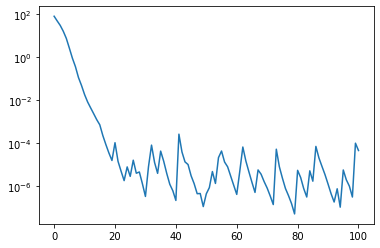

In [126]:
# fvalStable = fval
plt.semilogy(fvalStable)

In [157]:
fval[0:5],fvalOAMC[0:5]

([80.98257053605623,
  41.17216427052417,
  22.940531990682633,
  9.672888089388064,
  3.64677338647809],
 [80.98257053605623,
  43.9740250171089,
  21.202707827276008,
  8.940143408719749,
  3.7016130640772884])

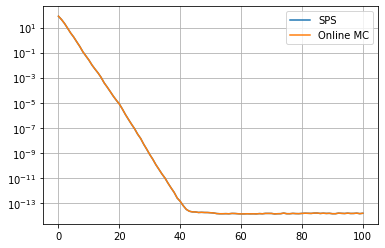

In [155]:
plt.semilogy(fval,label="SPS")
plt.semilogy(fvalOAMC,label="Online MC")
plt.legend()
plt.grid(True)

Text(0, 0.5, 'MSE')

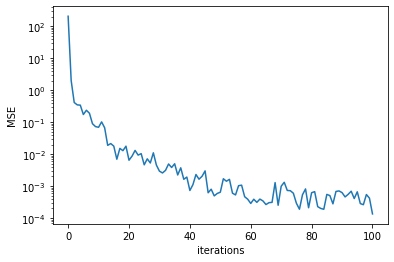

In [59]:
plt.semilogy(fval)
plt.xlabel("iterations")
plt.ylabel("MSE")


# ALS

In [13]:


# U =  np.random.randn(m,k) *0.01
# VT  =   np.random.randn(k,n)*0.01 

In [42]:
rs = [[] for j in range(m)]
cs = [[] for i in range(n)]

for j, i in OmegaOrig:
    rs[j].append(i)
    cs[i].append(j)
fvalLSA=[]
np.random.seed(1)
U = Us +np.random.randn(m,k)*0.9
VT  = VTs+ np.random.randn(k,n)*0.9


R = U@VT - A
fvalLSA.append(np.mean([  R[j,i]**2 for j,i in Omega ]))

for ep in range(100):
    R = U@VT - A
 
    for j in range(m):
#         np.random.shuffle(rs[j])
        if len(rs[j])>0:
            u = np.linalg.pinv(VT[:,rs[j] ].T) @ R[j,rs[j] ]
            U[j,:] -= u
        
    R = U@VT - A         
    for i in range(n):
        if len(cs[i])>0:
            v = np.linalg.pinv(U[ cs[i], : ]) @ R[ cs[i],i ]
            VT[:,i] -= v

            
    R = U@VT - A
    fvalLSA.append(np.mean([  R[j,i]**2 for j,i in Omega ]))
    

# ALS - online

In [87]:
rs = [[] for j in range(m)]
cs = [[] for i in range(n)]

eta = .9
for j, i in OmegaOrig:
    rs[j].append(i)
    cs[i].append(j)
fvalLSAOnline=[]
np.random.seed(1)
U = Us +np.random.randn(m,k)*0.9
VT  = VTs+ np.random.randn(k,n)*0.9


R = U@VT - A
fvalLSAOnline.append(np.mean([  R[j,i]**2 for j,i in Omega ]))

for ep in range(100):
    np.random.shuffle(Omega)
    for j,i in Omega:
        R = U@VT - A
        if np.random.rand(1)<0.5:
            c = i
            u = np.linalg.pinv(VT[:,c:c+1 ].T) @ R[j,c:c+1 ]
            U[j,:] -= eta*u
        else:
            r=j
            v = np.linalg.pinv(U[ r:r+1, : ]) @ R[ r:r+1,i ]
            VT[:,i] -= eta*v

            
    R = U@VT - A
    fvalLSAOnline.append(np.mean([  R[j,i]**2 for j,i in Omega ]))
    

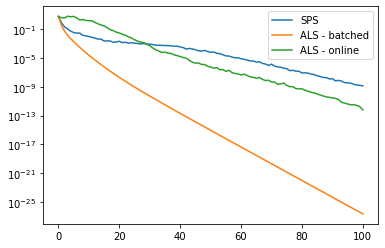

In [88]:
plt.semilogy(fval,label="SPS")
plt.semilogy(fvalLSA,label="ALS - batched")
plt.semilogy(fvalLSAOnline,label="ALS - online")
plt.legend()


In [331]:
VT[:,rs[j] ].T.shape, A[j,rs[j] ].shape

((13, 5), (13,))

In [336]:
roots

array([[-2.57221922+4.62866768j, -2.57221922-4.62866768j,
         0.03310517+0.j        ,  5.11133327-0.j        ]])

In [325]:
u <- u + du
v <- v + dv

array([[ 3.61873552, -4.2250083 ,  1.67603635, -2.09636641,  1.36163502,
        -2.90242325,  5.60008416, -2.30850662, -0.30143064,  0.94799001,
         4.42294381, -3.5149767 , -0.06820176],
       [-3.58084379,  8.00697116, -4.62531388,  0.13498541,  0.18810469,
        -2.68241849, -4.12322505,  0.99270166, -1.62849277,  8.82672435,
         3.92107686, -7.39747034, -5.33325479],
       [-6.76239121, -3.7411459 , -3.20358824,  5.10048264,  3.41405005,
         2.02339783,  0.42734207, -1.21243554, -3.79816118, -3.1684366 ,
        -3.62372062,  4.98154386,  2.21386265],
       [ 1.51397922, -0.41544923,  1.50738602,  0.81591474, -2.46015236,
         4.25495196, -1.46977011, -0.20734447,  2.91038442, -5.05223083,
         6.49780037, -4.29699537,  1.3514528 ],
       [ 3.85784854,  0.87017395,  5.22996924,  2.58863577,  4.35124382,
         4.19708706,  0.42594706,  6.69710929, -4.50458329, -1.68778718,
        -3.74709058,  0.21145962,  8.1548762 ]])

array([ 1.73002568,  2.93403814, -1.22158489, -0.47756704,  1.02500161,
       -1.56460858, -0.74759423,  0.94723392, -1.75898488,  3.20634946,
       -1.35936217,  0.60478711, -1.13212647])

In [206]:
solidx =  np.argmin(np.abs(np.imag(roots)))
print(solidx)
solidx  

2


0

In [290]:
rootssubsetion

array([-0.02078833+0.j,  3.7781964 -0.j])